In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Importing dependencies

In [2]:
!pip install wandb

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms

import os
import random
import numpy as np
import matplotlib.pyplot as plt

from tqdm.notebook import tqdm
import wandb
wandb.init(project="mnist-gans", name="gan")

W&B Run: https://app.wandb.ai/kad99kev/mnist-gans/runs/xxc5c2h5

# Data Loading

## Download and normalize to range [-1, 1]

In [4]:
dataset_train = torchvision.datasets.MNIST('./train', train=True, download=True, 
                                                  transform=transforms.Compose([transforms.ToTensor(), transforms.Normalize(mean=(0.5), std=(0.5))]))

In [5]:
dataset_test = torchvision.datasets.MNIST('./test', train=False, download=True, 
                                                  transform=transforms.Compose([transforms.ToTensor(), transforms.Normalize(mean=(0.5), std=(0.5))]))

In [6]:
# Change labels of dataset to real
dataset_train.targets = torch.ones(len(dataset_train))
dataset_test.targets = torch.ones(len(dataset_test))

In [7]:
labels_map = {0: 'Fake', 1: 'Real'}

## Concatenating train and test dataset

In [8]:
dataset = dataset_train + dataset_test
print(f'Length of complete dataset : {len(dataset)}')

Length of complete dataset : 70000


## Initializing constants

In [9]:
torch.cuda.is_available()

True

In [10]:
params = {}
params['epochs'] = 20
params['output_after_every_n_epochs'] = 1
params['image_size'] = 28
params['noise_size'] = 100
params['batch_size'] = 64
params['num_channels'] = 1
params['seed'] = 0
wandb.config.update(params)

In [11]:
# Function to help us plot batches (it is used with torchvision.utils.make_grid)
def show_grid(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

In [12]:
# Note: PyTorch does not guarantee reproducability
# Taken from https://www.kaggle.com/bminixhofer/deterministic-neural-networks-using-pytorch
def seed_everything(seed=0):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
seed_everything(params['seed'])

## Convert into DataLoader

In [13]:
datasetloader = torch.utils.data.DataLoader(dataset, batch_size=params['batch_size'], shuffle=True)

In [14]:
# This is just for visualization and a little debugging
dataiter = iter(datasetloader)

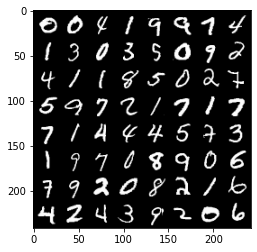

In [15]:
images, labels = dataiter.next()
show_grid(torchvision.utils.make_grid(images, normalize=True))

# Initialize Weights

In [16]:
def initialize_weights(m): 
	if type(m) == nn.Linear:
		torch.nn.init.xavier_uniform_(m.weight)
		m.bias.data.fill_(0.01)

# Generator Network

## Create Network

Hout = (Hin −1) × stride[0] − 2 × padding[0] + dilation[0] × (kernel_size[0] − 1) + output_padding[0] + 1

Wout = (Win −1) × stride[1] − 2 × padding[1] + dilation[1] × (kernel_size[1] − 1) + output_padding[1] + 1

In [17]:
class Generator(nn.Module):
  '''
  The Generator Network
  '''

  def __init__(self, input_size, image_size, num_channels):
    super(Generator, self).__init__()

    self.image_size = image_size
    self.num_channels = num_channels

    self.linear_1 = nn.Sequential(
        nn.Linear(input_size, 256),
        nn.LeakyReLU(0.2)
    )
    # Out 256

    self.linear_2 = nn.Sequential(
        nn.Linear(256, 512),
        nn.LeakyReLU(0.2)
    )
    # Out 512

    self.linear_3 = nn.Sequential(
        nn.Linear(512, 1024),
        nn.LeakyReLU(0.2),
    )
    # Out 1024

    self.output_layer = nn.Sequential(
        nn.Linear(1024, image_size ** 2),
        nn.Tanh()
    )
    # Out 784


    self.optimizer = optim.Adam(self.parameters(), lr=0.0002, betas=(0.5, 0.999))
  
  def forward(self, inputs):
    x = self.linear_1(inputs)
    x = self.linear_2(x)
    x = self.linear_3(x)
    generated_image = self.output_layer(x)
    return generated_image.view(generated_image.size(0), self.num_channels, self.image_size, self.image_size)

In [18]:
generator = Generator(params['noise_size'], params['image_size'], params['num_channels'])
generator.apply(initialize_weights)
generator.cuda()

Generator(
  (linear_1): Sequential(
    (0): Linear(in_features=100, out_features=256, bias=True)
    (1): LeakyReLU(negative_slope=0.2)
  )
  (linear_2): Sequential(
    (0): Linear(in_features=256, out_features=512, bias=True)
    (1): LeakyReLU(negative_slope=0.2)
  )
  (linear_3): Sequential(
    (0): Linear(in_features=512, out_features=1024, bias=True)
    (1): LeakyReLU(negative_slope=0.2)
  )
  (output_layer): Sequential(
    (0): Linear(in_features=1024, out_features=784, bias=True)
    (1): Tanh()
  )
)

## Test output shape of Generator

torch.Size([64, 1, 28, 28])


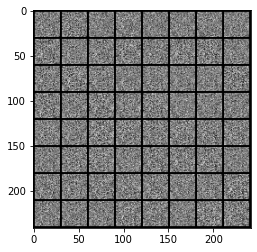

Generator(
  (linear_1): Sequential(
    (0): Linear(in_features=100, out_features=256, bias=True)
    (1): LeakyReLU(negative_slope=0.2)
  )
  (linear_2): Sequential(
    (0): Linear(in_features=256, out_features=512, bias=True)
    (1): LeakyReLU(negative_slope=0.2)
  )
  (linear_3): Sequential(
    (0): Linear(in_features=512, out_features=1024, bias=True)
    (1): LeakyReLU(negative_slope=0.2)
  )
  (output_layer): Sequential(
    (0): Linear(in_features=1024, out_features=784, bias=True)
    (1): Tanh()
  )
)

In [19]:
with torch.no_grad():
    generator.eval()
    _, labels = dataiter.next()
    noise = torch.randn(size=(params['batch_size'], params['noise_size'])).cuda()
    output = generator(noise).detach()
    print(output.shape)
show_grid(torchvision.utils.make_grid(output.cpu(), normalize=True))
generator.train()

# Discriminator Network

Hout = ( (Hin + 2 × padding[0] − dilation[0] × (kernel_size[0] − 1) - 1) / stride[0]) + 1

Wout = ( (Win + 2 × padding[1] − dilation[1] × (kernel_size[1] − 1) - 1) / stride[1]) + 1


In [20]:
class Discriminator(nn.Module):
  '''
  The Discriminator Network
  '''
  def __init__(self, image_size):
    super(Discriminator, self).__init__()

    self.image_size = image_size

    self.linear_1 = nn.Sequential(
        nn.Linear(image_size ** 2, 1024),
        nn.LeakyReLU(0.2),
        nn.Dropout(0.3)
    )
    # Out 1024
    
    self.linear_2 = nn.Sequential(
        nn.Linear(1024, 512),
        nn.LeakyReLU(0.2),
        nn.Dropout(0.3)
    )
    # Out 512

    self.linear_3 = nn.Sequential(
        nn.Linear(512, 256),
        nn.LeakyReLU(0.2),
        nn.Dropout(0.3)
    )
    # Out 256

    self.output_layer = nn.Sequential(
        nn.Linear(256, 1),
        nn.Sigmoid()
    )
    # Out 1

    self.optimizer = optim.Adam(self.parameters(), lr=0.0002, betas=(0.5, 0.999))
  
  def forward(self, inputs):
    x = inputs.view(inputs.size(0), self.image_size ** 2)
    x = self.linear_1(x)
    x = self.linear_2(x)
    x = self.linear_3(x)
    return self.output_layer(x) 

In [21]:
discriminator = Discriminator(params['image_size'])
discriminator.apply(initialize_weights)
discriminator.cuda()

Discriminator(
  (linear_1): Sequential(
    (0): Linear(in_features=784, out_features=1024, bias=True)
    (1): LeakyReLU(negative_slope=0.2)
    (2): Dropout(p=0.3, inplace=False)
  )
  (linear_2): Sequential(
    (0): Linear(in_features=1024, out_features=512, bias=True)
    (1): LeakyReLU(negative_slope=0.2)
    (2): Dropout(p=0.3, inplace=False)
  )
  (linear_3): Sequential(
    (0): Linear(in_features=512, out_features=256, bias=True)
    (1): LeakyReLU(negative_slope=0.2)
    (2): Dropout(p=0.3, inplace=False)
  )
  (output_layer): Sequential(
    (0): Linear(in_features=256, out_features=1, bias=True)
    (1): Sigmoid()
  )
)

# Specifying Loss function

In [22]:
adversarial_loss = nn.BCELoss()

# Plotting output after each epoch

In [23]:
# Fixed input noise
fixed_noise = torch.randn(size=(params['batch_size'], params['noise_size'])).cuda()
def save_output(epoch):
    plt.clf()
    with torch.no_grad():

        generator.eval()
        test_images = generator(fixed_noise)
        generator.train()

        grid = torchvision.utils.make_grid(test_images.cpu(), normalize=True)
        show_grid(grid)
    wandb.log({'output': wandb.Image(grid, caption=f'Output for epoch: {epoch}')}, step=epoch)

# Training GAN

Epoch: 1 / 20
Discriminator Total Loss: 0.650, Generator Total Loss: 1.855


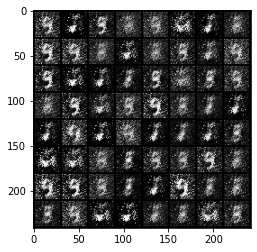

Epoch: 2 / 20
Discriminator Total Loss: 0.621, Generator Total Loss: 2.154


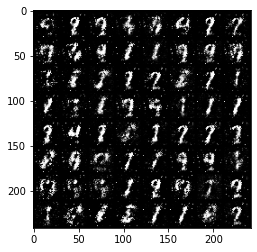

Epoch: 3 / 20
Discriminator Total Loss: 0.545, Generator Total Loss: 2.406


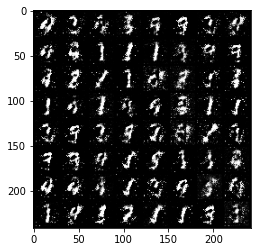

Epoch: 4 / 20
Discriminator Total Loss: 0.732, Generator Total Loss: 1.944


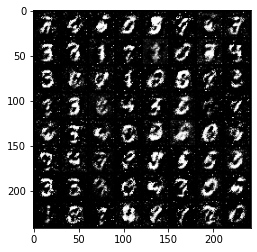

Epoch: 5 / 20
Discriminator Total Loss: 0.863, Generator Total Loss: 1.607


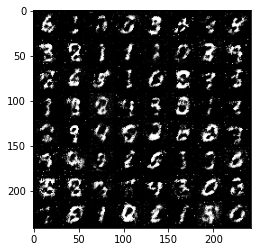

Epoch: 6 / 20
Discriminator Total Loss: 0.970, Generator Total Loss: 1.380


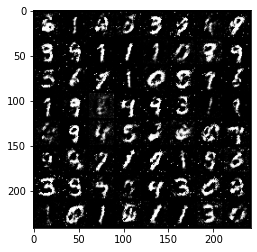

Epoch: 7 / 20
Discriminator Total Loss: 1.068, Generator Total Loss: 1.193


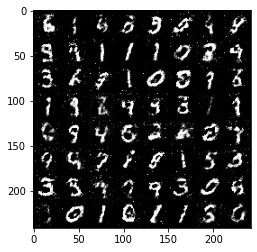

Epoch: 8 / 20
Discriminator Total Loss: 1.127, Generator Total Loss: 1.093


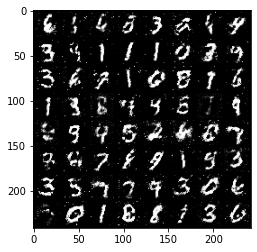

Epoch: 9 / 20
Discriminator Total Loss: 1.149, Generator Total Loss: 1.053


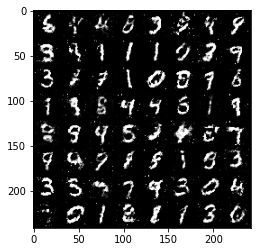

Epoch: 10 / 20
Discriminator Total Loss: 1.176, Generator Total Loss: 1.010


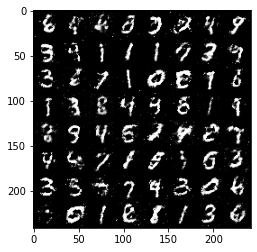

Epoch: 11 / 20
Discriminator Total Loss: 1.201, Generator Total Loss: 0.975


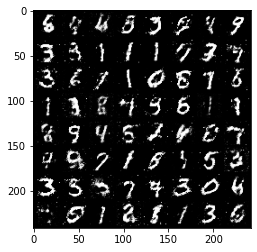

Epoch: 12 / 20
Discriminator Total Loss: 1.217, Generator Total Loss: 0.949


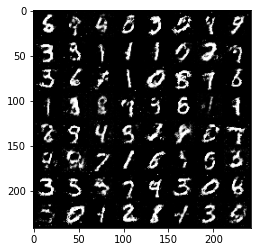

Epoch: 13 / 20
Discriminator Total Loss: 1.234, Generator Total Loss: 0.927


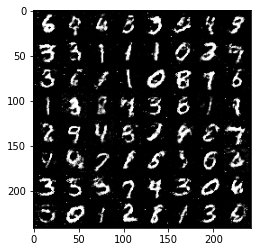

Epoch: 14 / 20
Discriminator Total Loss: 1.243, Generator Total Loss: 0.908


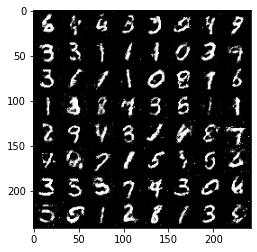

Epoch: 15 / 20
Discriminator Total Loss: 1.248, Generator Total Loss: 0.902


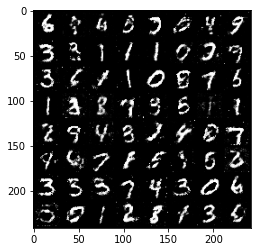

Epoch: 16 / 20
Discriminator Total Loss: 1.258, Generator Total Loss: 0.888


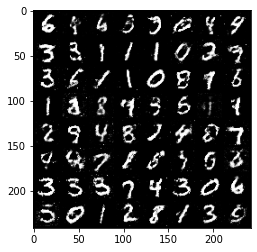

Epoch: 17 / 20
Discriminator Total Loss: 1.259, Generator Total Loss: 0.887


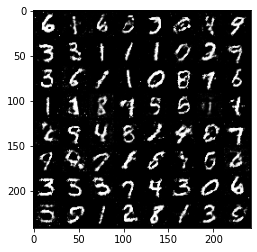

Epoch: 18 / 20
Discriminator Total Loss: 1.266, Generator Total Loss: 0.877


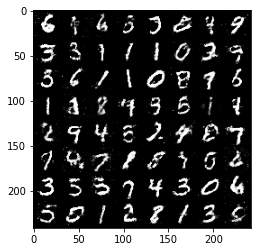

Epoch: 19 / 20
Discriminator Total Loss: 1.265, Generator Total Loss: 0.873


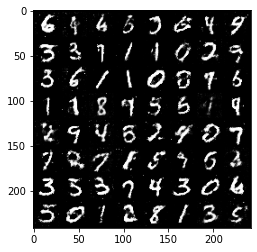

Epoch: 20 / 20
Discriminator Total Loss: 1.269, Generator Total Loss: 0.872


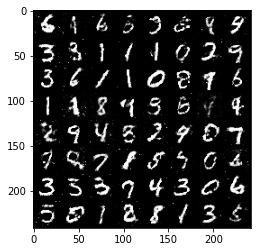

True

In [24]:
# Set tdqm for epoch progress
pbar = tqdm()

wandb.watch(generator)
wandb.watch(discriminator)
for epoch in range(params['epochs']):
  print(f'Epoch: {epoch + 1} / {params["epochs"]}')
  pbar.reset(total=len(datasetloader))

  # Setting up losses
  discriminator_total_losses = []
  generator_total_losses = []

  for real_images, real_labels in datasetloader:

    # Current batch size
    current_batch_size = real_images.size()[0]

    # Convert to cuda
    real_images = real_images.cuda()
    real_labels = real_labels.type('torch.FloatTensor').cuda() # Already converted to ones earlier
    fake_labels = torch.zeros(current_batch_size, dtype=torch.float).cuda()

    # Training Generator
    generator.zero_grad()

    ## Generate fake images
    input_noise = torch.randn(size=(current_batch_size, params['noise_size'])).cuda()
    fake_images = generator(input_noise)

    ## Calculate Generator loss
    discriminator_fake_labels = discriminator(fake_images)
    
    generator_total_loss = adversarial_loss(discriminator_fake_labels.squeeze(), real_labels)
    generator_total_loss.backward()
    generator.optimizer.step()
    generator_total_losses.append(generator_total_loss)

    # Training Discriminator
    discriminator.zero_grad()

    ## Loss for real images
    discriminator_real_labels = discriminator(real_images)
    discriminator_real_loss = adversarial_loss(discriminator_real_labels.squeeze(), real_labels)

    ## Loss for fake images
    discriminator_fake_labels = discriminator(fake_images.detach())
    discriminator_fake_loss = adversarial_loss(discriminator_fake_labels.squeeze(), fake_labels)

    ## Total loss
    discriminator_total_loss = discriminator_real_loss + discriminator_fake_loss
    discriminator_total_loss.backward()
    discriminator.optimizer.step()
    discriminator_total_losses.append(discriminator_total_loss)

    # Update tqdm
    pbar.update()

  print('Discriminator Total Loss: {:.3f}, Generator Total Loss: {:.3f}'.format(
          torch.mean(torch.FloatTensor(discriminator_total_losses)),
          torch.mean(torch.FloatTensor(generator_total_losses))
        ))
  
  wandb.log({"generator loss" : torch.mean(torch.FloatTensor(generator_total_losses)), "discriminator loss" : torch.mean(torch.FloatTensor(discriminator_total_losses))}, step=epoch+1)

  if (epoch + 1) % params['output_after_every_n_epochs'] == 0:
    save_output(epoch+1)

pbar.refresh()

In [25]:
generator.cpu().eval()
discriminator.cpu().eval()  
torch.save(generator.state_dict(), '/content/drive/My Drive/Incubator/saved_models/MNIST_GANS/generator.pt')
torch.save(discriminator.state_dict(), '/content/drive/My Drive/Incubator/saved_models/MNIST_GANS/discriminator.pt')
generator.train()
discriminator.train()

Discriminator(
  (linear_1): Sequential(
    (0): Linear(in_features=784, out_features=1024, bias=True)
    (1): LeakyReLU(negative_slope=0.2)
    (2): Dropout(p=0.3, inplace=False)
  )
  (linear_2): Sequential(
    (0): Linear(in_features=1024, out_features=512, bias=True)
    (1): LeakyReLU(negative_slope=0.2)
    (2): Dropout(p=0.3, inplace=False)
  )
  (linear_3): Sequential(
    (0): Linear(in_features=512, out_features=256, bias=True)
    (1): LeakyReLU(negative_slope=0.2)
    (2): Dropout(p=0.3, inplace=False)
  )
  (output_layer): Sequential(
    (0): Linear(in_features=256, out_features=1, bias=True)
    (1): Sigmoid()
  )
)